**Author:** Cainã Max Couto da Silva  
**LinkedIn:** [@cmcouto-silva](https://www.linkedin.com/in/cmcouto-silva/)

# Setup

## Importing libraries

In [ ]:
# %pip install scikit-learn==1.2.2

In [3]:
# Data wrangling
import numpy as np
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

## -- Machine learning -- ##

# Pipelines
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# Preprocessing / transformers
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import scale, StandardScaler, OneHotEncoder, PowerTransformer

# Models
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Model validation
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate

# For displyaing trees
import graphviz
from sklearn.tree import plot_tree, export_text, export_graphviz

# For displaying pipelines
from sklearn import set_config
set_config(display='diagram')
set_config(transform_output="pandas")

# For displyaing trees
import graphviz
from sklearn.tree import plot_tree, export_text, export_graphviz

# Imbalanced learn
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [4]:
def get_metrics(model, X, y):
  target_metrics = ['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall']
  return {metric: metrics.get_scorer(metric)(model, X, y) for metric in target_metrics}


def plot_tree_custom(clf : DecisionTreeClassifier, feature_names : list=None):
  # Get dot data
  dot_data = export_graphviz(
      decision_tree=clf,
      out_file=None,
      feature_names=feature_names,
      class_names=[str(c) for c in clf.classes_],
      filled=True
  )
  # Draw graph
  graph = graphviz.Source(dot_data, format="png")
  return graph

## Loading dataset

In [5]:
# Load dataset
df = pd.read_excel('https://public.dhe.ibm.com/software/data/sw-library/cognos/mobile/C11/data/Telco_customer_churn.xlsx', index_col=0)

# Removing columns that will not be used
columns_to_drop = [
    'Count',
    'Country',
    'State',
    'City',
    'Zip Code',
    'Lat Long',
    'Latitude',
    'Longitude',
    'Gender'
    ]
df.drop(columns=columns_to_drop, inplace=True)

# Fixing data types
df = df.assign(**{
    'Total Charges': lambda x: x['Total Charges'].replace({' ': np.NaN}).astype(float)
})

with pd.option_context('display.max_columns', None):
    display(df)

,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
CustomerID,,,,,,,,,,,,,,,,,,,,,,,
3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
9237-HQITU,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
9305-CDSKC,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes,1,86,5372,Moved
7892-POOKP,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
0280-XJGEX,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Yes,1,89,5340,Competitor had better devices
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2569-WGERO,No,No,No,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.40,No,0,45,5306,NaN
6840-RESVB,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,0,59,2140,NaN
2234-XADUH,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,0,71,5560,NaN


## Data quality checks

### Checking data types

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 3668-QPYBK to 3186-AJIEK
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Senior Citizen     7043 non-null   object 
 1   Partner            7043 non-null   object 
 2   Dependents         7043 non-null   object 
 3   Tenure Months      7043 non-null   int64  
 4   Phone Service      7043 non-null   object 
 5   Multiple Lines     7043 non-null   object 
 6   Internet Service   7043 non-null   object 
 7   Online Security    7043 non-null   object 
 8   Online Backup      7043 non-null   object 
 9   Device Protection  7043 non-null   object 
 10  Tech Support       7043 non-null   object 
 11  Streaming TV       7043 non-null   object 
 12  Streaming Movies   7043 non-null   object 
 13  Contract           7043 non-null   object 
 14  Paperless Billing  7043 non-null   object 
 15  Payment Method     7043 non-null   object 
 16  Monthly Charge

In [ ]:
df.select_dtypes(include='number').head()

,Tenure Months,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV
CustomerID,,,,,,
3668-QPYBK,2,53.85,108.15,1,86,3239
9237-HQITU,2,70.70,151.65,1,67,2701
9305-CDSKC,8,99.65,820.50,1,86,5372
7892-POOKP,28,104.80,3046.05,1,84,5003
0280-XJGEX,49,103.70,5036.30,1,89,5340


In [ ]:
df.select_dtypes(exclude='number').head()

,Senior Citizen,Partner,Dependents,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Churn Label,Churn Reason
CustomerID,,,,,,,,,,,,,,,,,
3668-QPYBK,No,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes,Competitor made better offer
9237-HQITU,No,No,Yes,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes,Moved
9305-CDSKC,No,No,Yes,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,Yes,Moved
7892-POOKP,No,Yes,Yes,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,Yes,Moved
0280-XJGEX,No,No,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),Yes,Competitor had better devices


### Checking missing values

In [ ]:
df.isna().sum().to_frame(name='missing_records').query('missing_records > 0')

,missing_records
Total Charges,11
Churn Reason,5174


### Checking categorical data

In [ ]:
df.select_dtypes(exclude='number').nunique()

Senior Citizen        2
Partner               2
Dependents            2
Phone Service         2
Multiple Lines        3
Internet Service      3
Online Security       3
Online Backup         3
Device Protection     3
Tech Support          3
Streaming TV          3
Streaming Movies      3
Contract              3
Paperless Billing     2
Payment Method        4
Churn Label           2
Churn Reason         20
dtype: int64

## Train/test split

In [9]:
target_variable = 'Churn Value'

X, y = df.drop(columns=[target_variable]), df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Data leakage analysis

## Feature with leaked data example

In [6]:
df_leak = df.select_dtypes('number').fillna(0)
df_leak

,Tenure Months,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV
CustomerID,,,,,,
3668-QPYBK,2,53.85,108.15,1,86,3239
9237-HQITU,2,70.70,151.65,1,67,2701
9305-CDSKC,8,99.65,820.50,1,86,5372
7892-POOKP,28,104.80,3046.05,1,84,5003
0280-XJGEX,49,103.70,5036.30,1,89,5340
...,...,...,...,...,...,...
2569-WGERO,72,21.15,1419.40,0,45,5306
6840-RESVB,24,84.80,1990.50,0,59,2140
2234-XADUH,72,103.20,7362.90,0,71,5560


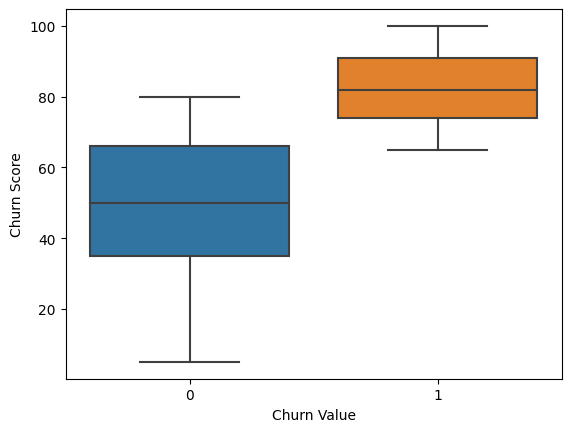

In [7]:
sns.boxplot(
    data=df_leak,
    x='Churn Value',
    y='Churn Score'
);

accuracy             0.887864
balanced_accuracy    0.781163
f1                   0.719858
precision            1.000000
recall               0.562327
dtype: float64 



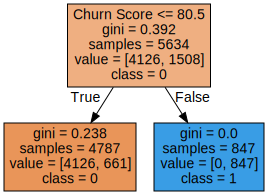

In [18]:
X_leak, y_leak = df_leak.drop(columns=[target_variable]), df_leak[target_variable]

X_leak_train, X_leak_test, y_leak_train, y_leak_test = train_test_split(
    X_leak, y_leak, test_size=0.2, random_state=0)

clf = DecisionTreeClassifier(max_depth=1).fit(X_leak_train, y_leak_train)
print(pd.Series(get_metrics(clf, X_leak_test, y_leak_test)), '\n')
plot_tree_custom(clf, feature_names=clf.feature_names_in_)

In [16]:
clf.feature_names_in_

array(['Tenure Months', 'Monthly Charges', 'Total Charges', 'Churn Score',
       'CLTV'], dtype=object)

# Pipelines

## Feature selection and missing strategy

### Numerical features

In [ ]:
numerical_features = [
    ('Tenure Months', 0),
    ('Monthly Charges', 'median'),
    ('CLTV', 'median'),
    ('Total Charges', 'median'),
]

numerical_features_input_median = [c for c, v in numerical_features if v == 'median']
numerical_features_input_zero = [c for c, v in numerical_features if v == 0]

pd.DataFrame(numerical_features, columns=['feature', 'missing_strategy'])

,feature,missing_strategy
0,Tenure Months,0
1,Monthly Charges,median
2,CLTV,median
3,Total Charges,median


### Categorical features

In [ ]:
categorical_features = [
    'Senior Citizen',
    'Partner',
    'Dependents',
    'Phone Service',
    'Multiple Lines',
    'Internet Service',
    'Online Security',
    'Online Backup',
    'Device Protection',
    'Tech Support',
    'Streaming TV',
    'Streaming Movies',
    'Contract',
    'Paperless Billing',
    'Payment Method',
    ]

print('Columns disconsidered: {}'.format(
    set(df.columns).difference([col for col, _ in numerical_features] + categorical_features)
))

Columns disconsidered: {'Churn Value', 'Churn Label', 'Churn Score', 'Churn Reason'}


## Creating pipeline for preprocessing & modelling

### Example 1: with Imputers + OneHotEncoder

#### Creating ColumnTransformers

In [ ]:
# Pipeline para transformação de variáveis numéricas
numeric_transformer_median = Pipeline(
    steps=[
        ('imputer_median', SimpleImputer(strategy='median')),
        ]
)

numeric_transformer_zero = Pipeline(
    steps=[
        ('imputer_zero', SimpleImputer(strategy='constant', fill_value=0)),
        ]
)

# Outra forma:
# numeric_transformer = make_pipeline(
#     SimpleImputer(strategy='median'),
# )
# numeric_transformer.named_steps

# Pipeline para transformação de variáveis categóricas
categorical_transformer = OneHotEncoder(sparse_output=False, drop='if_binary', handle_unknown='ignore')

# Pipeline de pré-processamento geral das variáveis (numéricas e categóricas)
preprocessor = ColumnTransformer(
    transformers=[
        ('num_median', numeric_transformer_median, numerical_features_input_median),
        ('num_zero', numeric_transformer_zero, numerical_features_input_zero),
        ('cat', categorical_transformer, categorical_features),
    ]
)

preprocessor

ColumnTransformer(transformers=[('num_median',
                                 Pipeline(steps=[('imputer_median',
                                                  SimpleImputer(strategy='median'))]),
                                 ['Monthly Charges', 'CLTV', 'Total Charges']),
                                ('num_zero',
                                 Pipeline(steps=[('imputer_zero',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'))]),
                                 ['Tenure Months']),
                                ('cat',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Senior Citizen', 'Partner', 'Dependents',
                                  'Phone Service', 'Multiple Lines',
                                  'Internet Service', 'Online Security',
                                  'Online Backup', 'Device Protection',
                                  'Tech Support', 'Streaming TV',
                                  'Streaming Movies', 'Contract',
                                  'Paperless Billing', 'Payment Method'])])

#### Creating full pipeline

In [ ]:
clf_pipeline_e1 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=0, n_estimators=10, max_depth=3))
    ]
)
clf_pipeline_e1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_median',
                                                  Pipeline(steps=[('imputer_median',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Monthly Charges', 'CLTV',
                                                   'Total Charges']),
                                                 ('num_zero',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['Tenure Months']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_un...'ignore',
                                                                sparse_output=False),
                                                  ['Senior Citizen', 'Partner',
                                                   'Dependents',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Internet Service',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection',
                                                   'Tech Support',
                                                   'Streaming TV',
                                                   'Streaming Movies',
                                                   'Contract',
                                                   'Paperless Billing',
                                                   'Payment Method'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=3, n_estimators=10,
                                        random_state=0))])

In [ ]:
clf_pipeline_e1.fit(X_train, y_train)
pd.Series(get_metrics(clf_pipeline_e1, X_test, y_test))

accuracy             0.782115
balanced_accuracy    0.630177
f1                   0.428305
precision            0.653409
recall               0.318560
dtype: float64

#### Accessing objects within the pipeline with .named_steps:

In [ ]:
clf_pipeline_e1.named_steps.keys()

dict_keys(['preprocessor', 'classifier'])

In [ ]:
clf = clf_pipeline_e1.named_steps['classifier']
clf.estimators_

[DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=209652396),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=398764591),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=924231285),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                        random_state=1478610112),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=441365315),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                        random_state=1537364731),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=192771779),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                        random_state=1491434855),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                        random_state=1819583497),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=530702035)]

In [ ]:
dt = clf[0]

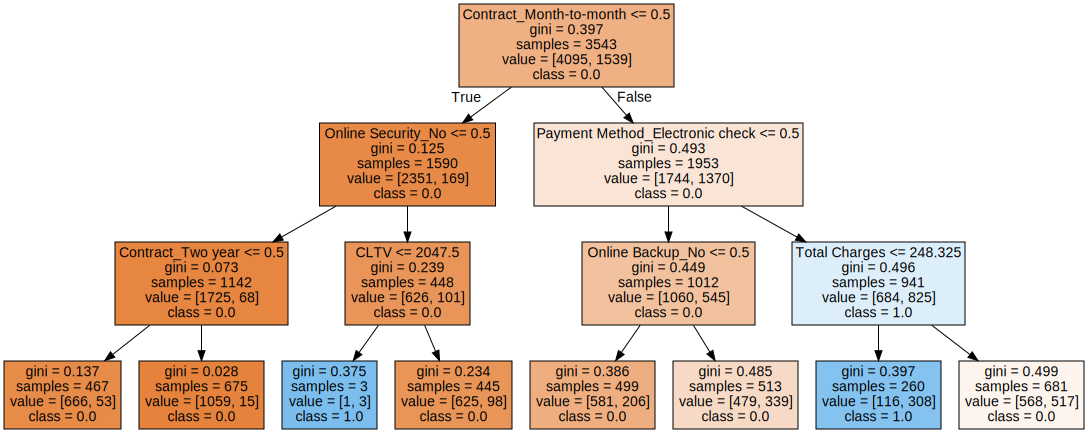

In [ ]:
plot_tree_custom(dt, [feature.split('__')[1] for feature in clf.feature_names_in_])

### Example 2: adding Scalers, PCA & GridSearchCV

In [ ]:
numeric_transformer_median = Pipeline(
    steps=[
        ('imputer_median', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()) # Added
        ]
)

numeric_transformer_zero = Pipeline(
    steps=[
        ('imputer_zero', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler()) # Added
        ]
)

categorical_transformer = OneHotEncoder(sparse_output=False, drop='if_binary', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num_median', numeric_transformer_median, numerical_features_input_median),
        ('num_zero', numeric_transformer_zero, numerical_features_input_zero),
        ('cat', categorical_transformer, categorical_features),
    ]
)

clf_pipeline_e2 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('pca', PCA()),
        ('logreg', LogisticRegression(max_iter=10000, tol=0.1)),
    ]
)

clf_pipeline_e2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_median',
                                                  Pipeline(steps=[('imputer_median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Monthly Charges', 'CLTV',
                                                   'Total Charges']),
                                                 ('num_zero',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Tenure M...
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Senior Citizen', 'Partner',
                                                   'Dependents',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Internet Service',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection',
                                                   'Tech Support',
                                                   'Streaming TV',
                                                   'Streaming Movies',
                                                   'Contract',
                                                   'Paperless Billing',
                                                   'Payment Method'])])),
                ('pca', PCA()),
                ('logreg', LogisticRegression(max_iter=10000, tol=0.1))])

In [ ]:
print(f'''
For the hyperparameter grid, we should use the following syntax for the dict keys: "named_step"__"hyperparameter_argument_name".
The named steps are: {clf_pipeline_e2.named_steps.keys()}
''')

param_grid = {
    'pca__n_components': [8, 12, 15],
    'logreg__C': np.logspace(-3, 3, 7),
}

search_pipeline_e2 = GridSearchCV(clf_pipeline_e2, param_grid, scoring='f1', n_jobs=-1)
search_pipeline_e2


For the hyperparameter grid, we should use the following syntax for the dict keys: "named_step"__"hyperparameter_argument_name".
The named steps are: dict_keys(['preprocessor', 'pca', 'logreg'])



GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_median',
                                                                         Pipeline(steps=[('imputer_median',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Monthly '
                                                                          'Charges',
                                                                          'CLTV',
                                                                          'Total '
                                                                          'Charges']),
                                                                        ('num_zero',
                                                                         Pipeline(steps=[('imputer_zero',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          St...
                                                                          'Online '
                                                                          'Backup',
                                                                          'Device '
                                                                          'Protection',
                                                                          'Tech '
                                                                          'Support',
                                                                          'Streaming '
                                                                          'TV',
                                                                          'Streaming '
                                                                          'Movies',
                                                                          'Contract',
                                                                          'Paperless '
                                                                          'Billing',
                                                                          'Payment '
                                                                          'Method'])])),
                                       ('pca', PCA()),
                                       ('logreg',
                                        LogisticRegression(max_iter=10000,
                                                           tol=0.1))]),
             n_jobs=-1,
             param_grid={'logreg__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'pca__n_components': [8, 12, 15]},
             scoring='f1')

In [ ]:
search_pipeline_e2.fit(X_train, y_train)
print(f'Best hyperparameters: {search_pipeline_e2.best_params_}')
pd.Series(get_metrics(search_pipeline_e2.best_estimator_, X_test, y_test))

Best hyperparameters: {'logreg__C': 1.0, 'pca__n_components': 15}


accuracy             0.793471
balanced_accuracy    0.703182
f1                   0.562406
precision            0.615132
recall               0.518006
dtype: float64

### Example 3: Adding balancing strategy

In [ ]:
clf_pipeline_e3 = ImbPipeline(
    steps=[
        ('oversampler', RandomOverSampler(sampling_strategy=1., random_state=0)), # Added
        ('preprocessor', preprocessor),
        ('classifier', SVC(C=1)),
    ]
)

clf_pipeline_e3.fit(X_train, y_train)
pd.Series(get_metrics(clf_pipeline_e3, X_test, y_test))

accuracy             0.750177
balanced_accuracy    0.756702
f1                   0.612335
precision            0.508227
recall               0.770083
dtype: float64

### Example 4: Pipeline & GridSearchCV for model selection

In [ ]:
clf_pipeline_e4 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', DummyClassifier())
    ]
)

clf_pipeline_e4

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_median',
                                                  Pipeline(steps=[('imputer_median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Monthly Charges', 'CLTV',
                                                   'Total Charges']),
                                                 ('num_zero',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Tenure M...,
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Senior Citizen', 'Partner',
                                                   'Dependents',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Internet Service',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection',
                                                   'Tech Support',
                                                   'Streaming TV',
                                                   'Streaming Movies',
                                                   'Contract',
                                                   'Paperless Billing',
                                                   'Payment Method'])])),
                ('model', DummyClassifier())])

In [ ]:
grid_params = {
    'model': [DummyClassifier(), LogisticRegression(max_iter=1000), RandomForestClassifier()]
}

grid_search_e4 = GridSearchCV(clf_pipeline_e4, grid_params, n_jobs=-1)
grid_search_e4.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_median',
                                                                         Pipeline(steps=[('imputer_median',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Monthly '
                                                                          'Charges',
                                                                          'CLTV',
                                                                          'Total '
                                                                          'Charges']),
                                                                        ('num_zero',
                                                                         Pipeline(steps=[('imputer_zero',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          St...
                                                                          'Service',
                                                                          'Multiple '
                                                                          'Lines',
                                                                          'Internet '
                                                                          'Service',
                                                                          'Online '
                                                                          'Security',
                                                                          'Online '
                                                                          'Backup',
                                                                          'Device '
                                                                          'Protection',
                                                                          'Tech '
                                                                          'Support',
                                                                          'Streaming '
                                                                          'TV',
                                                                          'Streaming '
                                                                          'Movies',
                                                                          'Contract',
                                                                          'Paperless '
                                                                          'Billing',
                                                                          'Payment '
                                                                          'Method'])])),
                                       ('model', DummyClassifier())]),
             n_jobs=-1,
             param_grid={'model': [DummyClassifier(),
                                   LogisticRegression(max_iter=1000),
                                   RandomForestClassifier()]})

In [ ]:
grid_search_e4.best_params_

{'model': LogisticRegression(max_iter=1000)}

In [ ]:
grid_search_e4.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_median',
                                                  Pipeline(steps=[('imputer_median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Monthly Charges', 'CLTV',
                                                   'Total Charges']),
                                                 ('num_zero',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Tenure M...
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Senior Citizen', 'Partner',
                                                   'Dependents',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Internet Service',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection',
                                                   'Tech Support',
                                                   'Streaming TV',
                                                   'Streaming Movies',
                                                   'Contract',
                                                   'Paperless Billing',
                                                   'Payment Method'])])),
                ('model', LogisticRegression(max_iter=1000))])